# Import Dataset

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import sklearn
import json

In [2]:
folder_path = "images"

# Load Image and Labels

In [3]:
def load_image(image_path):
  image = cv2.imread(image_path)
  if image is None:
    print('Error: Could not load image.')
    return None, None
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  return image, gray

In [4]:
dataset_dir = '/content/images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _, image = load_image(os.path.join(root, f))
    if image is None:
      continue
    images.append(image)
    labels.append(root.split('/')[-1])

In [5]:
sample_image, sample_gray = load_image("/Users/benedictaedita/Downloads/images/Billie_Eilish/billie_8.jpeg")

Error: Could not load image.


[ WARN:0@11.906] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/benedictaedita/Downloads/images/Billie_Eilish/billie_8.jpeg'): can't open/read file: check file path/integrity


(-0.5, 336.5, 435.5, -0.5)

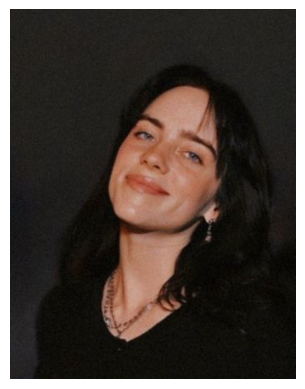

In [69]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)
plt.axis("off")

(-0.5, 336.5, 435.5, -0.5)

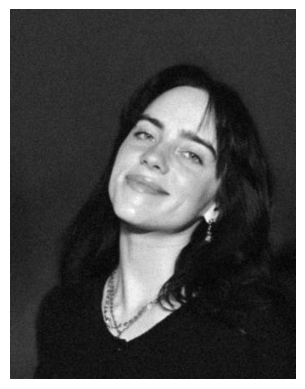

In [70]:
plt.imshow(sample_gray, cmap='gray')
plt.axis('off')              

In [121]:
dataset_dir = '/Users/benedictaedita/Downloads/images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  print(root, dirs, files)
  if len(files) == 0:
    continue
  for f in files:
    _, image = load_image(os.path.join(root, f))
    if image is None:
      continue
    images.append(image)
    labels.append(root.split('/')[-1])

/Users/benedictaedita/Downloads/images ['Vladimir_Putin', 'Anna_Shumate', 'Billie_Eilish', 'Benedicta_Edita', 'Laura_Bush', 'George_W_Bush', 'Serena_Williams'] ['.DS_Store']
Error: Could not load image.
/Users/benedictaedita/Downloads/images/Vladimir_Putin [] ['8.jpg', '9.jpg', '10.jpg', '4.jpg', '5.jpg', '7.jpg', '6.jpg', '2.jpg', '3.jpg', '1.jpg']
/Users/benedictaedita/Downloads/images/Anna_Shumate [] ['anna_20.jpeg', '.DS_Store', 'anna_2.jpeg', 'anna_21.jpeg', 'anna_10.jpeg', 'anna_26.jpg', 'anna_5.jpeg', 'anna_19.jpg', 'anna_9.jpeg', 'anna_18.jpg', 'anna_8.jpeg', 'anna_23.jpg', 'anna_4.jpeg', 'anna_22.jpg', 'anna_13.jpg', 'anna_3.jpg', 'anna_7.jpeg', 'anna_12.jpg', 'anna_24.jpeg', 'anna_1.jpg', 'anna_11.jpg', 'anna_15.jpg', 'anna_25.jpeg', 'anna_14.jpg', 'anna_16.jpg', 'anna_6.jpeg', 'anna_17.jpg']
Error: Could not load image.
/Users/benedictaedita/Downloads/images/Billie_Eilish [] ['.DS_Store', 'billie_22.jpeg', 'billie_9.jpg', 'billie_3.jpeg', 'billie_25.jpeg', 'billie_8.jpeg', '

In [107]:
len(labels)

107

# Face Detection

In [122]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [123]:
def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5, min_size=(30, 30)):
  faces = face_cascade.detectMultiScale(image_gray,
                                        scaleFactor=scale_factor,
                                        minNeighbors=min_neighbors,
                                        minSize=min_size
                                        )
  return faces

In [124]:
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces

In [125]:
sample_face = detect_faces(sample_gray)

(-0.5, 154.5, 154.5, -0.5)

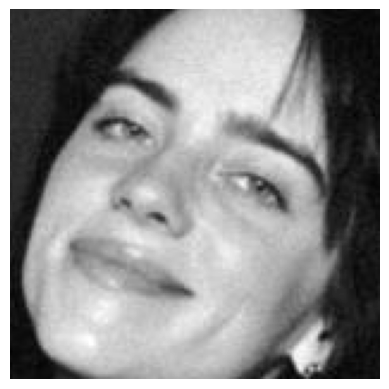

In [126]:
sample_image_face, _ = crop_faces(sample_gray, sample_face)
plt.imshow(sample_image_face[0], cmap='gray')
plt.axis("off")

# Face Recognition

In [129]:
face_size = (128, 128)
def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten()
  return face_flattened

In [130]:
X = []
y = []

for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_faces, _ = crop_faces(image, faces)
  if len(cropped_faces) > 0:
    face_flattened = resize_and_flatten(cropped_faces[0])
    X.append(face_flattened)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [139]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis=0)
    return self
  def transform(self, X):
    return X - self.mean_face

In [140]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

pipe = Pipeline([('centering', MeanCentering()),
  ('pca', PCA(svd_solver='randomized', whiten=True, random_state=177)),
  ('svc', SVC(kernel='linear', random_state=177))
  ])

In [141]:
from sklearn.metrics import classification_report

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   Anna_Shumate       0.50      0.33      0.40         3
Benedicta_Edita       0.50      0.67      0.57         3
  Billie_Eilish       0.50      0.20      0.29         5
  George_W_Bush       0.20      0.50      0.29         2
     Laura_Bush       0.67      1.00      0.80         2
Serena_Williams       0.00      0.00      0.00         2
 Vladimir_Putin       0.50      0.50      0.50         2

       accuracy                           0.42        19
      macro avg       0.41      0.46      0.41        19
   weighted avg       0.43      0.42      0.40        19



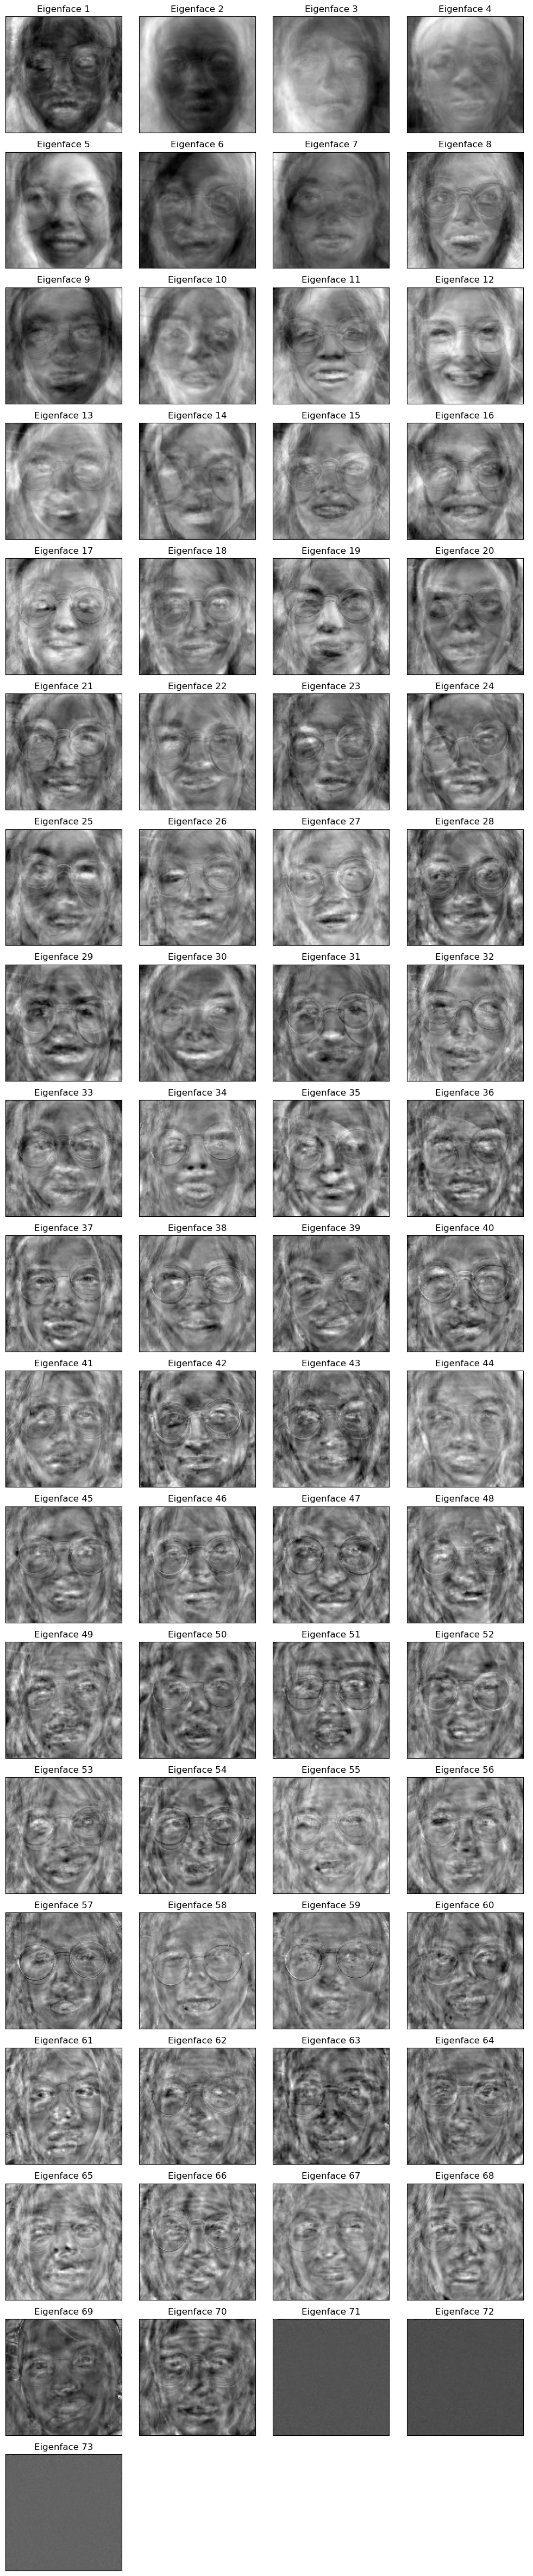

In [142]:
n_components = len(pipe[1].components_)

ncol = 4
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),subplot_kw={'xticks':[], 'yticks':[]})

eigenfaces = pipe[1].components_.reshape((n_components, X_train.shape[1]))
for i in range(n_components):
  ax = axes.flat[i]
  ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
  ax.set_title(f'Eigenface {i+1}')

for i in range(n_components, len(axes.flat)):
  axes.flat[i].axis('off')

plt.tight_layout()
plt.show()


In [143]:
import pickle

with open('eigenface_pipeline.pkl', 'wb') as f:
  pickle.dump(pipe, f)

In [144]:
def get_eigenface_score(X):
  X_pca = pipe[:2].transform(X)
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
  return eigenface_scores

In [146]:
def eigenface_prediction(image_gray):
  faces = detect_faces(image_gray)
  cropped_faces, selected_faces = crop_faces(image_gray, faces)
  if len(cropped_faces) == 0:
    return 'No face detected.'

  X_face = []
  for face in cropped_faces:
    face_flattened = resize_and_flatten(face)
    X_face.append(face_flattened)

  X_face = np.array(X_face)
  labels = pipe.predict(X_face)
  scores = get_eigenface_score(X_face)
  return scores, labels, selected_faces

In [147]:
sample_score, sample_labels, sample_face = eigenface_prediction(sample_gray)

In [148]:
def draw_text(image, label, score,
              font=cv2.FONT_HERSHEY_SIMPLEX,
              pos=(0, 0),
              font_scale=0.6,
              font_thickness=2,
              text_color=(0, 0, 0),
              text_color_bg=(0, 255, 0)
              ):
  x, y = pos
  score_text = f'Score: {score:.2f}'
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale, font_thickness)
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y), text_color_bg, -1)
  cv2.putText(image, label, (x+10, y-10), font, font_scale, text_color, font_thickness)
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale, text_color, font_thickness)

In [149]:
def draw_result(image, scores, labels, coords):
  result_image = image.copy()
  for (x, y, w, h), label, score in zip(coords, labels, scores):
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    draw_text(result_image, label, score, pos=(x, y))
    return result_image

(-0.5, 336.5, 435.5, -0.5)

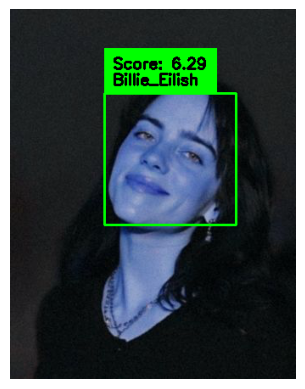

In [150]:
result = draw_result(sample_image, sample_score, sample_labels, sample_face)
plt.imshow(result)
plt.axis("off")

# Real-Time Face Recognition

In [151]:
DATASET_PATH = "./dataset"
HAAR_CASCADE_PATH = "haarcascade_frontalface_default.xml"
MODEL_PATH = "face_model.yml"
LABELS_PATH = "label_map.json"

face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_PATH)
recognizer = cv2.face.LBPHFaceRecognizer_create()

current_id = 0
label_ids = {}
x_train = []
y_labels = []

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.lower().endswith(("png", "jpg", "jpeg")):
            path = os.path.join(root, file)
            label = os.path.basename(root)
            if label not in label_ids:
                label_ids[label] = current_id
                current_id += 1
            id_ = label_ids[label]

            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            faces = face_cascade.detectMultiScale(image, scaleFactor=1.3, minNeighbors=5)

            for (x, y, w, h) in faces:
                roi = image[y:y + h, x:x + w]
                x_train.append(roi)
                y_labels.append(id_)

print("[INFO] Training...")
recognizer.train(x_train, np.array(y_labels))
recognizer.save(MODEL_PATH)
print(f"[INFO] Model saved to {MODEL_PATH}")

with open(LABELS_PATH, 'w') as f:
    json.dump({v: k for k, v in label_ids.items()}, f)
print(f"[INFO] Label map saved to {LABELS_PATH}")


[INFO] Training...
[INFO] Model saved to face_model.yml
[INFO] Label map saved to label_map.json


In [152]:
HAAR_CASCADE_PATH = "haarcascade_frontalface_default.xml"
MODEL_PATH = "face_model.yml"
LABELS_PATH = "label_map.json"

if not os.path.exists(HAAR_CASCADE_PATH):
    raise FileNotFoundError(f"Haar Cascade not found at {HAAR_CASCADE_PATH}")
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_PATH)

recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.read(MODEL_PATH)
print("[DEBUG] Model loaded from:", MODEL_PATH)
print("[DEBUG] Recognizer threshold:", recognizer.getThreshold())

with open(LABELS_PATH, "r") as f:
    labels = json.load(f)
labels = {int(k): v for k, v in labels.items()}

cap = cv2.VideoCapture(0)
print("[INFO] Starting webcam... Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y + h, x:x + w]
        id_, confidence = recognizer.predict(roi_gray)
        name = labels.get(id_, "Unknown")
        color = (0, 255, 0) if confidence < 90 else (0, 0, 255)

        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, f"{name} ({round(confidence, 1)})", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    cv2.imshow("Face Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[DEBUG] Model loaded from: face_model.yml
[DEBUG] Recognizer threshold: 1.7976931348623157e+308


[ WARN:0@11933.162] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


[INFO] Starting webcam... Press 'q' to quit.
